# **Deep Reinforcement Learning**

Objectives: Train Deep Reinforcement Learning methods on the [CArt Pole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) and [Bipedal Walker](https://www.gymlibrary.dev/environments/box2d/bipedal_walker/) OpenAI Gym environments

1.   Improve the DQN agent already implemented by modifying the DQN, or by searching for better parameters
2.   Apply Policy-based/Actor Critic agent to the Bipedal Walker environment







To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

Install needed Python packages

In [ ]:
!pip install pygame gym[box2D] numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import basic Python packages

In [ ]:
import gym
from gym import spaces
import pygame
import numpy as np

Mount Google Drive for saving results (not needed if running the notebook locally)

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)              # we mount the google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Video Utilities

In [ ]:
from pathlib import Path
import base64
from IPython import display as ipythondisplay
from gym.wrappers import RecordVideo

In [ ]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
def record_video_randpol(env, video_length=0, step_trigger=None, episode_trigger=None,  prefix='', video_folder='videos/'):

  video_env = RecordVideo(env, 
                         video_folder=video_folder,
                         episode_trigger=episode_trigger,
                         step_trigger=step_trigger,
                         video_length=video_length,
                         name_prefix=prefix,
                         new_step_api=True
                         )
  
  observation = video_env.reset()

  step = 0
  ep = 0

  while True:

    if _iterate_condition(step, ep, video_length=video_length, step_trigger=step_trigger, episode_trigger=episode_trigger):

      observation, reward, terminated, _, info = video_env.step(env.action_space.sample())
      step += 1

      if terminated:
        observation = video_env.reset()
        ep += 1
        step = 0
    
    else:
      break
      
  video_env.close()

# Utility function for checking stopping condition
def _iterate_condition(step, ep, video_length=0, step_trigger=None, episode_trigger=None):

  if video_length is not 0:
    go = True if step < video_length else False
    return go

  if step_trigger is not None:
    go = step_trigger(step)
    return go

  if episode_trigger is not None:
    go = episode_trigger(ep)
    return go

In [ ]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

# **1) Improve DQN Agent on `CartPole-v0`**

## Inspect `CartPole-v0` environment

Initialize environment with discrete action space (necessary for DQN)

In [ ]:
env = gym.make(
    "CartPole-v0",
    new_step_api=True
)

Record and show video

In [ ]:
import sys
import os

is_colab = 'google.colab' in sys.modules
root_dir ='drive/MyDrive/CASAdvancedML' if is_colab else '.'

In [ ]:
video_folder = os.path.join(root_dir, 'Videos')
os.makedirs(video_folder, exist_ok =True)

prefix = 'cart_random'

record_video_randpol(env,
                     video_length=0,
                     episode_trigger=lambda ep: ep == 0,
                     step_trigger=None,
                     prefix=prefix,
                     video_folder=video_folder)

show_videos(video_folder, prefix=prefix)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/CASAdvancedML/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

In [ ]:
print('The action space of the environment is of dimension: {}'.format(env.action_space.n))
print('The observation space of the environment is of dimension {}'.format(env.observation_space.sample().shape))

The action space of the environment is of dimension: 2
The observation space of the environment is of dimension (4,)


## Deep Q-Learning Agent

**Replay Memory**: The agent needs a memory buffer to sample experience from

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):

        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self):
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return (torch.from_numpy(self.obs_buf[idxs]).to(self.device),
                torch.from_numpy(self.acts_buf[idxs]).long().to(self.device),
                torch.from_numpy(self.rews_buf[idxs]).to(self.device),
                torch.from_numpy(self.next_obs_buf[idxs]).to(self.device),
                torch.from_numpy(self.done_buf[idxs]).to(self.device))

    def __len__(self):
        return self.size

**DQN**: The Q network that returns Q-values for state-action pairs

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, action_size, input_dim=1):
        super(DQN, self).__init__()

        self.action_size = action_size 

        # Network
        self.f1 =  nn.Linear(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.f2 = nn.Linear(32, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.head = nn.Linear(32, self.action_size)

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):

        x = x.to(self.device)

        x = F.relu(self.bn1(self.f1(x)))
        x = F.relu(self.bn2(self.f2(x)))
        
        return self.head(x)
        

**Agent**: The Python class featuring the main learning steps for the DQN agent

In [ ]:
from math import tau
from torch import optim
import random

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, dqn, memory, lr=1e-4, batch_size=64, update_every=5, gamma=0.99, tau=1e-3, epsilon=0.1, seed=0, render=False, optimal=False):
        """Initialize an Agent object.
        
        Params
        ======
            dqn (nn.Module): Module implementing the DQN
            memory (object): Replay buffer object
            seed (int): Random seed
        """

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-Network
        self.qnetwork_local = dqn.to(self.device)
        self.qnetwork_target = dqn.to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Other params
        self.lr = lr
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon

        self.render = render
        self.optimal = optimal

        # Replay memory
        self.memory = memory
        # Initialize time step (for updating every update_every steps)
        self.t_step = 0

    def episode(self, env, max_steps=1000):
        
        state = env.reset()
        score = 0

        if self.render:
          env.render()

        for _ in range(max_steps):
            
            action = self.act(state, self.epsilon)
            a = env.step(action)
            next_state, reward, done, _, info = env.step(action)
            
            if not(self.optimal):
              self.step(state, action, reward, next_state, done)
              
            state = next_state
            score += reward
            if done:
                break

        return score

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) >  self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (1 - dones.unsqueeze(1)))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions.unsqueeze(1))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)                     

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.qnetwork_local.action_size))

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


**Main training function**: the function that trains the agent on the environment

In [ ]:
from tqdm import tqdm

def DeepQLearning(env: gym.Env, agent: object, num_episodes: int, max_steps=1000, save_model=None):

  reward_per_ep = list()

  for i in tqdm(range(num_episodes)):
    reward = agent.episode(env, max_steps=max_steps)
    reward_per_ep.append(reward)
  
  if save_model is not None:
    torch.save(agent.qnetwork_local.state_dict(), save_model)

  return reward_per_ep

## Training & Evaluation

Define parameters and initialize modules

In [ ]:
# set parameters of the Agent and ReplayBuffer
lr = 1e-4
batch_size = 64
update_every = 5 
gamma = 0.99
tau = 0.5
epsilon = 0.1

buffer_size=int(1e+3)
seed=0

# instantiate Q-network
dqn = DQN(action_size=env.action_space.n,
          input_dim=env.observation_space.shape[0])

# instantiate memory buffer
memory = ReplayBuffer(obs_dim=env.observation_space.shape[0],
                      size=buffer_size,
                      batch_size=batch_size)
# instantiate agent
agent = Agent(dqn,
              memory,
              lr=lr,
              batch_size=batch_size,
              update_every=update_every, 
              gamma=gamma,
              tau=tau,
              epsilon=epsilon)

# number of episodes and file path to save the model
num_episodes = 5000
model_dir = os.path.join(root_dir, 'Models')
save_model = os.path.join(model_dir, 'ffdqn_{}episodes.pth'.format(num_episodes))
os.makedirs(model_dir, exist_ok =True)

Run training loop

In [ ]:
R = DeepQLearning(env, agent, num_episodes, save_model=save_model)

100%|██████████| 5000/5000 [02:16<00:00, 36.66it/s]


Plot learning curve (i.e., average reward over fixed window)

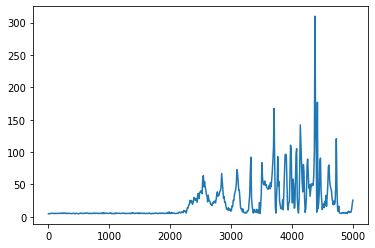

In [ ]:
from matplotlib import pyplot as plt

def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

window = 10
t,y = averagewindow(R, d=window)
plt.plot(t, y)

In [ ]:
import os

# set parameters to evaluate agent
agent.optimal = True
agent.epsilon = 0.0
vid_episodes = 5
prefix = os.path.basename(save_model).split('.')[0]

# use wrapper to record videos
env_vid = RecordVideo(env, 
                      video_folder=video_folder,
                      episode_trigger=lambda ep: (ep < vid_episodes),
                      step_trigger=None,
                      video_length=0,
                      name_prefix=prefix,
                      new_step_api=True
                      )

# use wrapper to record videos
R_test = DeepQLearning(env_vid, agent, vid_episodes)


/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/CASAdvancedML/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "
  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument m

In [ ]:
show_videos(video_folder, prefix=prefix)

## Improve the current agent

Pick (at least) one of the following tasks:

1.   Look for better hyper-parameters of the algorithm (e.g., learning rate, batch size, epsilon, etc.).
2.   Focus on the DQN architecture. For instance, add regularization techniques (e.g., dropout) in the current feed-forward network. Otherwise, you could embed temporal information into the Q network by using the [Frame Stack](https://www.gymlibrary.dev/api/wrappers/#available-wrappers) wrapper for feeding sequential data and [Recurrent](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)/[Attention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) layers for processing them.



In [ ]:
# TO COMPLETE

# **2) Implement Deep RL Algorithm on `BipedalWalker-v3`**

Further documentation for this environment is available [here](https://www.gymlibrary.dev/environments/box2d/bipedal_walker/).

Note: this environment does not provide discrete actions. Therefore, the vanilla DQN algorithm can't be applied without discretizing etc.
Implement a policy/actor-critic approach to deal with continous action spaces.

Hint: You can modify the previously defined `Agent` class to implement the [Deep Deterministic Policy Gradient](https://arxiv.org/pdf/1509.02971.pdf) (DDPG) algorithm (check in particular Algorithm 1 of the paper). Most of the Deep RL algorthms need replay buffers, so the `ReplayBuffer` class can be directly re-used.
Also, many implementations online (e.g., https://spinningup.openai.com/en/latest/_modules/spinup/algos/pytorch/ddpg/ddpg.html)

Instantiate `BipedalWalker-v3` environment

In [ ]:
env = gym.make(
    "BipedalWalker-v3",
    new_step_api=True
)

Record and show video

In [ ]:
prefix = 'bipwalk_random'

record_video_randpol(env,
                     video_length=100,
                     episode_trigger=None,
                     step_trigger=None,
                     prefix=prefix,
                     video_folder=video_folder)

show_videos(video_folder, prefix=prefix)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/CASAdvancedML/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "
/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitoring/video_recorder.py:79: DeprecationWarning: WARN: Recording ability for environment BipedalWalker-v3 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  f"Recording ability for environment {env.spec.id} initialized with `render_mode=None` is marked "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecat

Update `Agent` class and write additional required classes

In [ ]:
# TO COMPLETE